In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
from rdkit import Chem
import numpy as np
import pandas as pd
import copy
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import Linear
from torch.nn import BatchNorm1d
import torch.optim as optim
from torch.utils.data import Dataset
from torch_geometric.nn import GCNConv, GATConv
from torch_geometric.nn import global_add_pool
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import confusion_matrix, f1_score
import warnings
warnings.filterwarnings(action='ignore')

In [2]:
paser = argparse.ArgumentParser()
args = paser.parse_args("")
args.seed = 2023
    
np.random.seed(args.seed)
torch.manual_seed(args.seed)
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=1)

In [3]:
def one_of_k_encoding_unk(x, allowable_set):
    if x not in allowable_set:
        x = allowable_set[-1]
    return list(map(lambda s: x == s, allowable_set))

def atom_features(atom):
    results = np.array(one_of_k_encoding_unk(atom.GetSymbol(), ['B', 'C', 'Cl', 'N', 'O', 'P', 'S']) + 
                       one_of_k_encoding_unk(atom.GetDegree(), [1, 2, 3, 4]) + 
                       one_of_k_encoding_unk(atom.GetImplicitValence(), [0, 1, 2, 3]) + 
                       [atom.GetFormalCharge(), atom.GetNumRadicalElectrons()] + 
                       one_of_k_encoding_unk(atom.GetHybridization(), [Chem.rdchem.HybridizationType.SP, 
                                                                       Chem.rdchem.HybridizationType.SP2, 
                                                                       Chem.rdchem.HybridizationType.SP3, 
                                                                       Chem.rdchem.HybridizationType.SP3D, 
                                                                       Chem.rdchem.HybridizationType.SP3D2]) + 
                       [atom.GetIsAromatic()]+
                       one_of_k_encoding_unk(atom.GetTotalNumHs(), [0, 1, 2, 3]))
    return results
 

def get_bond_pair(mol):
    bonds = mol.GetBonds()
    res = [[],[]]
    for bond in bonds:
        res[0] += [bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()]
        res[1] += [bond.GetEndAtomIdx(), bond.GetBeginAtomIdx()]
    return res
 
def mol2vec(mol):
    atoms = mol.GetAtoms()
    node_feat= [atom_features(atom) for atom in atoms]
    edge_index = get_bond_pair(mol)
    data = Data(x=torch.tensor(node_feat, dtype=torch.float),
                edge_index=torch.tensor(edge_index, dtype=torch.long))
    return data

In [4]:
def make_mol(df):
    mols = {}
    for i in range(df.shape[0]):
        mols[Chem.MolFromSmiles(df['SMILES'].iloc[i])] = df['Class'].iloc[i]
    return mols

In [5]:
def make_vec(mols):
    X = [mol2vec(m) for m in mols.keys()]
    for i, data in enumerate(X):
        y = list(mols.values())[i]
        data.y = torch.tensor([y], dtype=torch.long)
    return X

In [6]:
df = pd.read_csv('./LMSD_dataset.csv')
classes = {c:i for i,c in enumerate(df['Category'].unique())}
df['Class'] = 0
for i in range(df.shape[0]):
    df.loc[i, 'Class'] = classes[df['Category'].iloc[i]]
df

,SMILES,Category,Class
0,C=CCCCCC(C)CCCCCC#CCCC(OC)C(=O)OC(=O)C(CCC#CCC...,Fatty Acyls,0
1,CCCCCCC[C@H](O)CC(=O)N[C@@H](CO)C(=O)O,Fatty Acyls,0
2,CCCCCCCCCCCCCCCC(=O)OC(CCCCCCCCCCCCCC)CC(=O)N[...,Fatty Acyls,0
3,CC/C=C\C/C=C\C/C=C\CCCCCCCC(=O)N[C@@H](CCC(N)=...,Fatty Acyls,0
4,CC(C)CCCCCCCCCCCCCC(=O)OC(CCCCCCCCCCCC(C)C)CC(...,Fatty Acyls,0
...,...,...,...
47334,CCCCCCCCCCC[C@H](CC1=CC(=O)C=C(OC)C1=O)OC(C)=O,Polyketides,7
47335,CCCCCCCCCCCC1=C(O)C(=O)C=C(O)C1=O,Polyketides,7
47336,CCCCCCCCCCCC1=C(O)C(=O)C=C(OC)C1=O,Polyketides,7
47337,CCCCCCCCCCCCCCCC1=C(O)C(=O)C=C(O)C1=O,Polyketides,7


In [7]:
df['Class'].value_counts()

0    10550
2    10018
1     7739
7     7145
3     4533
4     3627
5     2382
6     1345
Name: Class, dtype: int64

In [8]:
X_train, X_test = train_test_split(df, 
                                   test_size=0.2, 
                                   shuffle=True, 
                                   stratify=df['Class'], 
                                   random_state=args.seed)
X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
len(X_train), len(X_test)

(37871, 9468)

In [9]:
train_mols = make_mol(X_train)
test_mols = make_mol(X_test)

train_X = make_vec(train_mols)
test_X = make_vec(test_mols)

len(train_X), len(test_X)

(37871, 9468)

In [10]:
class GCNlayer(nn.Module):
    
    def __init__(self, n_features, conv_dim1, conv_dim2, conv_dim3, concat_dim, dropout):
        super(GCNlayer, self).__init__()
        self.dropout = dropout
        
        self.conv1 = GCNConv(n_features, conv_dim1)
        self.bn1 = BatchNorm1d(conv_dim1)
        self.conv2 = GCNConv(conv_dim1, conv_dim2)
        self.bn2 = BatchNorm1d(conv_dim2)
        self.conv3 = GCNConv(conv_dim2, conv_dim3)
        self.bn3 = BatchNorm1d(conv_dim3)
        self.conv4 = GCNConv(conv_dim3, concat_dim)
        
        
    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(self.bn1(x), p=self.dropout)
        x = F.relu(self.conv2(x, edge_index))
        x = F.dropout(self.bn2(x), p=self.dropout)
        x = F.dropout(x, p=self.dropout)
        x = F.relu(self.conv3(x, edge_index))
        x = F.dropout(self.bn3(x), p=self.dropout)
        x = F.relu(self.conv4(x, edge_index))
        x = global_add_pool(x, data.batch)
        return x
    
class FClayer(nn.Module):
    
    def __init__(self, concat_dim, pred_dim1, pred_dim2, pred_dim3, out_dim, dropout):
        super(FClayer, self).__init__()
        self.dropout = dropout

        self.fc1 = Linear(concat_dim, pred_dim1)
        self.bn1 = BatchNorm1d(pred_dim1)
        self.fc2 = Linear(pred_dim1, pred_dim2)
        self.bn2 = BatchNorm1d(pred_dim2)
        self.fc3 = Linear(pred_dim2, pred_dim3)
        self.bn3 = BatchNorm1d(pred_dim3)
        self.fc4 = Linear(pred_dim3, out_dim)
    
    def forward(self, data):
        x = F.relu(self.fc1(data))
        x = F.dropout(self.bn1(x), p=self.dropout)
        x = F.relu(self.fc2(x))
        x = F.dropout(self.bn2(x), p=self.dropout)
        x = F.relu(self.fc3(x))
        x = F.dropout(self.bn3(x), p=self.dropout)
        x = self.fc4(x)
        return x
    
class Net(nn.Module):
    def __init__(self, args):
        super(Net, self).__init__()
        self.conv = GCNlayer(args.n_features, 
                              args.conv_dim1, 
                              args.conv_dim2, 
                              args.conv_dim3, 
                              args.concat_dim, 
                              args.dropout)
        self.fc = FClayer(args.concat_dim, 
                          args.pred_dim1, 
                          args.pred_dim2, 
                          args.pred_dim3, 
                          args.out_dim, 
                          args.dropout)
        
    def forward(self, data):
        x = self.conv(data)
        x = self.fc(x)
        x = F.log_softmax(x, dim=1)
        return x

In [11]:
class EarlyStopping:
    def __init__(self, patience=20, verbose=False, delta=0):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta

    def __call__(self, val_loss, model):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.counter = 0

In [12]:
def train(model, device, optimizer, train_loader, criterion, args, prints):
    y_true = []
    y_pred = []
    epoch_loss = 0
    for i, data in enumerate(train_loader):
        data = data.to(device)
        labels = data.y.to(device)
        outputs = model(data)
        loss = criterion(outputs, labels)
        epoch_loss += loss
        optimizer.zero_grad()
        loss.backward()
        y_pred.extend(outputs.cpu().detach().max(axis=1).indices.tolist())
        y_true.extend(labels.cpu().detach().tolist())
    epoch_loss /= len(train_loader)
    return model, epoch_loss.tolist(), y_true, y_pred

def test(model, device, test_loader, criterion, args, prints):
    y_true = []
    y_pred = []
    epoch_loss = 0
    model.eval()
    with torch.no_grad():
        for i, data in enumerate(test_loader):
            data = data.to(device)
            labels = data.y.to(device)
            outputs = model(data)
            loss = criterion(outputs, labels)
            epoch_loss += loss
            y_pred.extend(outputs.cpu().detach().max(axis=1).indices.tolist())
            y_true.extend(labels.cpu().detach().tolist())
    epoch_loss /= len(train_loader)
    return model, epoch_loss.tolist(), y_true, y_pred

def results(true, pred):
    cm = confusion_matrix(true, pred)
    micf1 = f1_score(true, pred, average='micro')
    macf1 = f1_score(true, pred, average='macro')
    print('Micro F1 Score : %.2f' % micf1)
    print('Macro F1 Score : %.2f' % macf1)
    return cm, micf1, macf1

def experiment(model, train_loader, test_loader, device, args, prints=True):
    
    optimizer = optim.Adam(model.parameters(),lr=args.lr)
    criterion = nn.CrossEntropyLoss()
    scheduler = optim.lr_scheduler.StepLR(optimizer,
                                          step_size=args.step_size,
                                          gamma=args.gamma)
    early_stopping = EarlyStopping(patience=args.patience, verbose=True)
    
    list_train_loss = []
    list_test_loss = []
    if prints:
        print('[Train]')
    for epoch in range(args.epoch):
        optimizer.step()
        scheduler.step()
        model, train_loss, _, _ = train(model, device, optimizer, train_loader, criterion, args, prints)
        model, test_loss, y_true, y_pred = test(model, device, test_loader, criterion, args, prints)
        list_train_loss.append(train_loss)
        list_test_loss.append(test_loss)
        if prints:
            print('- Epoch: %d\t- Train Loss: %.4f\t- Test Loss: %.4f' % (epoch+1, train_loss, test_loss))
        early_stopping(test_loss, model)
        if early_stopping.early_stop:
            print("Early stopping")
            break
    if prints:
        print('[Tets]')
    model, test_loss, y_true, y_pred = test(model, device, test_loader, criterion, args, prints)
    
    cm, micf1, macf1 = results(y_true, y_pred)
    
    args.list_train_loss = list_train_loss
    args.list_test_loss = list_test_loss
    args.y_true = y_true
    args.y_pred = y_pred
    args.cm = cm
    args.micf1 = micf1
    args.macf1 = macf1
    
    return args

In [13]:
def plot_result(result_df):
    
    figsize = 4
    label_fs = 14
    legend_fs = 12
    ticks_fs = 12

    train_loss = result_df['list_train_loss'].iloc[0]
    test_loss = result_df['list_test_loss'].iloc[0]
    y_true = result_df['y_true'].iloc[0]
    y_pred = result_df['y_pred'].iloc[0]
    classes = result_df['classes'].iloc[0]
    cm, micf1, macf1 = results(y_true, y_pred)
    
    cm_matrix = pd.DataFrame(cm, 
                             index=classes, 
                             columns=classes)
    plt.figure(figsize=(figsize+1, figsize))
    sns.heatmap(cm_matrix.astype('int'), annot=True, cmap='Blues', fmt="d", 
               xticklabels=classes, yticklabels=classes, annot_kws={"size": 8})
    plt.tick_params(left=False, bottom=False)
    plt.xlabel('Predicted Class', fontsize=label_fs)
    plt.ylabel('True Class', fontsize=label_fs)
    plt.xticks(fontsize=ticks_fs)
    plt.yticks(fontsize=ticks_fs)
    plt.show()
    
    plt.figure(figsize=(figsize, figsize))
    plt.plot([e for e in range(len(train_loss))], [float(t) for t in train_loss], label="Train Loss", c='blue')
    plt.plot([e for e in range(len(train_loss))], [float(t) for t in test_loss], label="Test Loss", c='red')
    plt.xlabel("Epoch", fontsize=label_fs)
    plt.ylabel("Loss", fontsize=label_fs)
    plt.xticks(fontsize=ticks_fs)
    plt.yticks(fontsize=ticks_fs)
    plt.legend(fontsize=legend_fs)
    plt.show()
    
    return cm, micf1, macf1

In [14]:
args.batch_size = 512
args.optim = 'Adam'
args.step_size = 10
args.gamma = 0.9
args.dropout = 0.2
args.lr = 0.0001
args.epoch = 1000
args.patience = 50
args.n_features = 27
conv_dim = 128
args.conv_dim1 = conv_dim
args.conv_dim2 = conv_dim
args.conv_dim3 = conv_dim
args.concat_dim = 128
args.pred_dim1 = 128
args.pred_dim2 = 64
args.pred_dim3 = 32
args.out_dim = len(classes)
args.classes = [k for k in classes.keys()]

model = Net(args)
model = model.to(device)

train_loader = DataLoader(train_X, batch_size=args.batch_size, shuffle=True, drop_last=False)
test_loader = DataLoader(test_X, batch_size=args.batch_size, shuffle=False, drop_last=False)

dict_result = dict()
args.exp_name = f'Exp'
result = vars(experiment(model, train_loader, test_loader, device, args, prints=True))
dict_result[args.exp_name] = copy.deepcopy(result)
torch.cuda.empty_cache()

result_df = pd.DataFrame(dict_result).transpose()
result_df.to_csv(f'./result.csv', index=False)

[Train]
- Epoch: 1	- Train Loss: 2.2060	- Test Loss: 0.5648
- Epoch: 2	- Train Loss: 2.1595	- Test Loss: 0.5553
- Epoch: 3	- Train Loss: 2.1027	- Test Loss: 0.5417
- Epoch: 4	- Train Loss: 2.0423	- Test Loss: 0.5240
- Epoch: 5	- Train Loss: 1.9861	- Test Loss: 0.5123
- Epoch: 6	- Train Loss: 1.9452	- Test Loss: 0.4991
- Epoch: 7	- Train Loss: 1.8989	- Test Loss: 0.4861
- Epoch: 8	- Train Loss: 1.8553	- Test Loss: 0.4779
- Epoch: 9	- Train Loss: 1.8212	- Test Loss: 0.4712
- Epoch: 10	- Train Loss: 1.7821	- Test Loss: 0.4576
- Epoch: 11	- Train Loss: 1.7533	- Test Loss: 0.4523
- Epoch: 12	- Train Loss: 1.7281	- Test Loss: 0.4464
- Epoch: 13	- Train Loss: 1.6977	- Test Loss: 0.4375
- Epoch: 14	- Train Loss: 1.6697	- Test Loss: 0.4330
- Epoch: 15	- Train Loss: 1.6426	- Test Loss: 0.4242
- Epoch: 16	- Train Loss: 1.6196	- Test Loss: 0.4179
- Epoch: 17	- Train Loss: 1.5947	- Test Loss: 0.4088
- Epoch: 18	- Train Loss: 1.5725	- Test Loss: 0.4065
- Epoch: 19	- Train Loss: 1.5511	- Test Loss: 0

- Epoch: 155	- Train Loss: 0.6913	- Test Loss: 0.1803
- Epoch: 156	- Train Loss: 0.6910	- Test Loss: 0.1805
- Epoch: 157	- Train Loss: 0.6926	- Test Loss: 0.1785
- Epoch: 158	- Train Loss: 0.6908	- Test Loss: 0.1773
- Epoch: 159	- Train Loss: 0.6947	- Test Loss: 0.1792
- Epoch: 160	- Train Loss: 0.6889	- Test Loss: 0.1785
- Epoch: 161	- Train Loss: 0.6879	- Test Loss: 0.1811
- Epoch: 162	- Train Loss: 0.6849	- Test Loss: 0.1797
- Epoch: 163	- Train Loss: 0.6848	- Test Loss: 0.1784
- Epoch: 164	- Train Loss: 0.6814	- Test Loss: 0.1784
- Epoch: 165	- Train Loss: 0.6834	- Test Loss: 0.1770
- Epoch: 166	- Train Loss: 0.6795	- Test Loss: 0.1778
- Epoch: 167	- Train Loss: 0.6769	- Test Loss: 0.1785
- Epoch: 168	- Train Loss: 0.6717	- Test Loss: 0.1801
- Epoch: 169	- Train Loss: 0.6790	- Test Loss: 0.1754
- Epoch: 170	- Train Loss: 0.6769	- Test Loss: 0.1768
- Epoch: 171	- Train Loss: 0.6724	- Test Loss: 0.1753
- Epoch: 172	- Train Loss: 0.6747	- Test Loss: 0.1782
- Epoch: 173	- Train Loss: 0

- Epoch: 307	- Train Loss: 0.6014	- Test Loss: 0.1562
- Epoch: 308	- Train Loss: 0.5946	- Test Loss: 0.1572
- Epoch: 309	- Train Loss: 0.5987	- Test Loss: 0.1548
- Epoch: 310	- Train Loss: 0.5996	- Test Loss: 0.1546
- Epoch: 311	- Train Loss: 0.5994	- Test Loss: 0.1568
- Epoch: 312	- Train Loss: 0.6040	- Test Loss: 0.1582
- Epoch: 313	- Train Loss: 0.6014	- Test Loss: 0.1571
- Epoch: 314	- Train Loss: 0.5943	- Test Loss: 0.1542
- Epoch: 315	- Train Loss: 0.5976	- Test Loss: 0.1575
- Epoch: 316	- Train Loss: 0.5886	- Test Loss: 0.1544
- Epoch: 317	- Train Loss: 0.5953	- Test Loss: 0.1558
- Epoch: 318	- Train Loss: 0.5947	- Test Loss: 0.1534
- Epoch: 319	- Train Loss: 0.5953	- Test Loss: 0.1554
- Epoch: 320	- Train Loss: 0.5981	- Test Loss: 0.1551
- Epoch: 321	- Train Loss: 0.5935	- Test Loss: 0.1530
- Epoch: 322	- Train Loss: 0.5959	- Test Loss: 0.1553
- Epoch: 323	- Train Loss: 0.5959	- Test Loss: 0.1552
- Epoch: 324	- Train Loss: 0.5931	- Test Loss: 0.1568
- Epoch: 325	- Train Loss: 0

- Epoch: 459	- Train Loss: 0.5848	- Test Loss: 0.1514
- Epoch: 460	- Train Loss: 0.5811	- Test Loss: 0.1513
- Epoch: 461	- Train Loss: 0.5814	- Test Loss: 0.1517
- Epoch: 462	- Train Loss: 0.5882	- Test Loss: 0.1517
- Epoch: 463	- Train Loss: 0.5815	- Test Loss: 0.1513
- Epoch: 464	- Train Loss: 0.5814	- Test Loss: 0.1520
- Epoch: 465	- Train Loss: 0.5782	- Test Loss: 0.1535
- Epoch: 466	- Train Loss: 0.5795	- Test Loss: 0.1513
- Epoch: 467	- Train Loss: 0.5803	- Test Loss: 0.1487
- Epoch: 468	- Train Loss: 0.5816	- Test Loss: 0.1527
- Epoch: 469	- Train Loss: 0.5756	- Test Loss: 0.1498
- Epoch: 470	- Train Loss: 0.5799	- Test Loss: 0.1519
- Epoch: 471	- Train Loss: 0.5832	- Test Loss: 0.1508
- Epoch: 472	- Train Loss: 0.5813	- Test Loss: 0.1506
- Epoch: 473	- Train Loss: 0.5840	- Test Loss: 0.1548
- Epoch: 474	- Train Loss: 0.5820	- Test Loss: 0.1497
- Epoch: 475	- Train Loss: 0.5803	- Test Loss: 0.1512
- Epoch: 476	- Train Loss: 0.5820	- Test Loss: 0.1503
- Epoch: 477	- Train Loss: 0

Micro F1 Score : 0.86
Macro F1 Score : 0.81


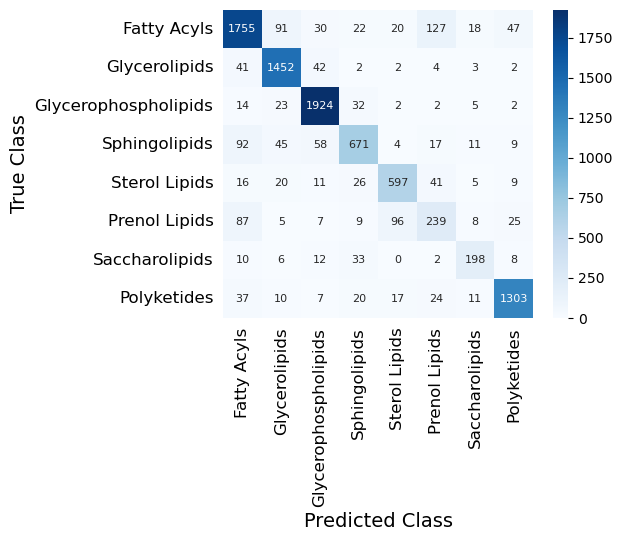

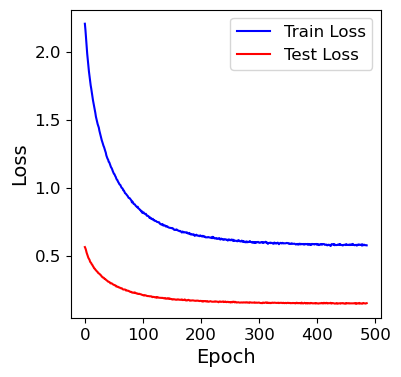

In [15]:
cm, micf1, macf1 = plot_result(result_df)